#Turkey vs France


 
 DATA SAMPLE (2010-2024)
  Year Country  Total_Vehicles  Electric  EV_Market_Share_Pct
2010.0  France       7766730.0     335.0             0.004313
2011.0  France       7772815.0    2824.0             0.036332
2012.0  France       7411389.0    6220.0             0.083925
2013.0  France       7304038.0   10663.0             0.145988
2014.0  France       7379151.0   13824.0             0.187339
2015.0  France       7597799.0   21328.0             0.280713
2016.0  France       7799933.0   26955.0             0.345580
2017.0  France       7937525.0   33891.0             0.426972
2018.0  France       7952319.0   44885.0             0.564427
2019.0  France       8131096.0   63944.0             0.786413
2020.0  France       7385575.0  141734.0             1.919065
2021.0  France       7862763.0  224629.0             2.856871
2022.0  France       6917361.0  281994.0             4.076612
2023.0  France       7145894.0  394487.0             5.520471
2024.0  France       7240424.0  435223.0  

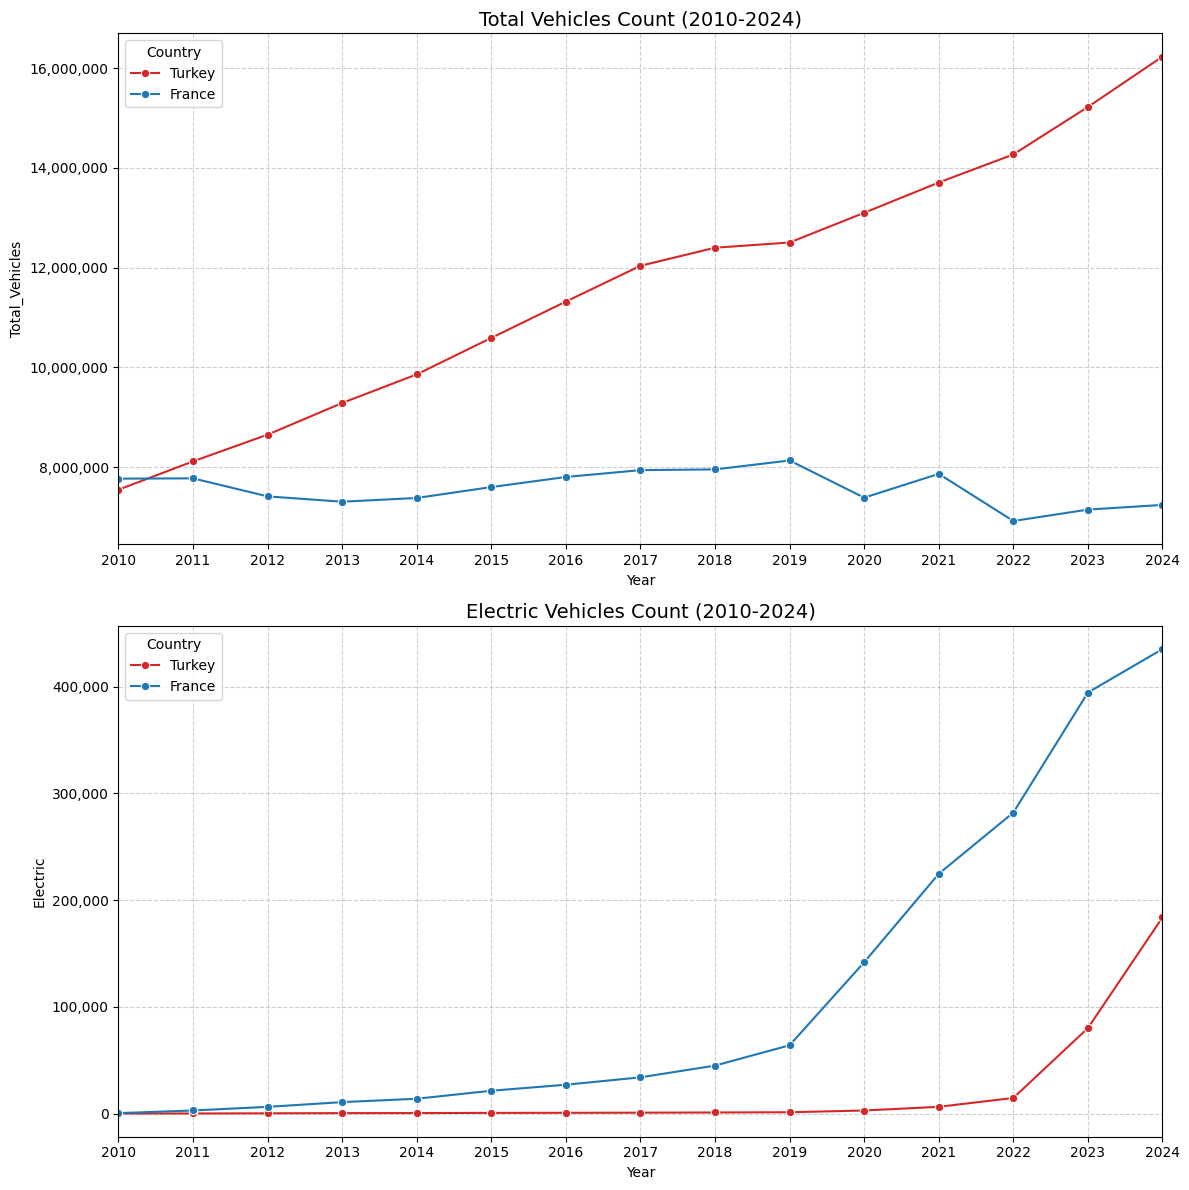

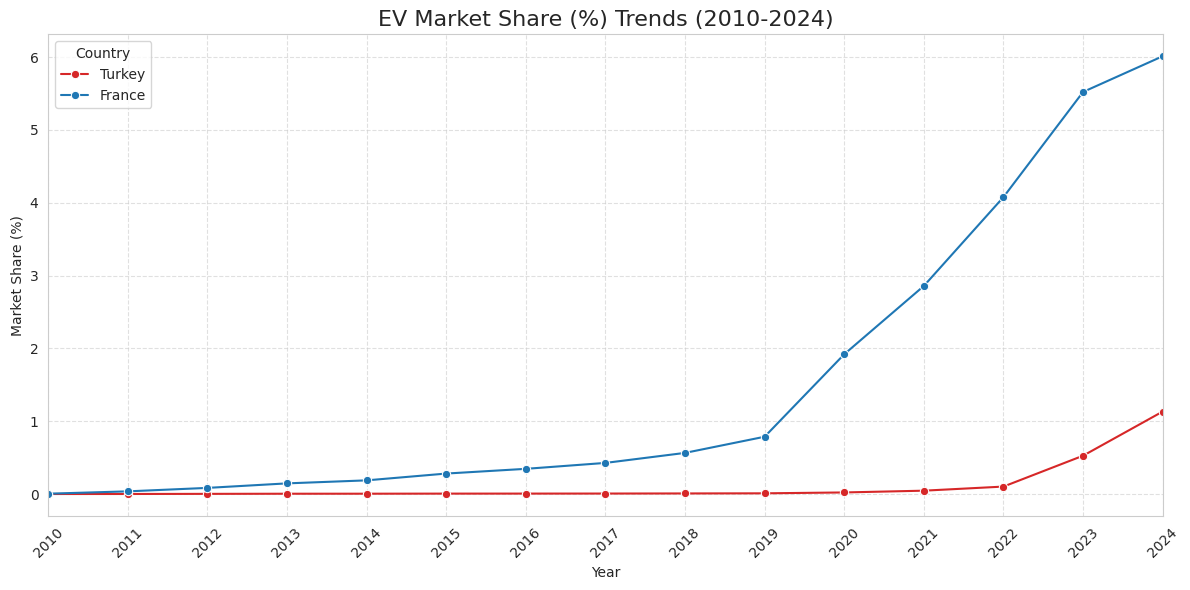

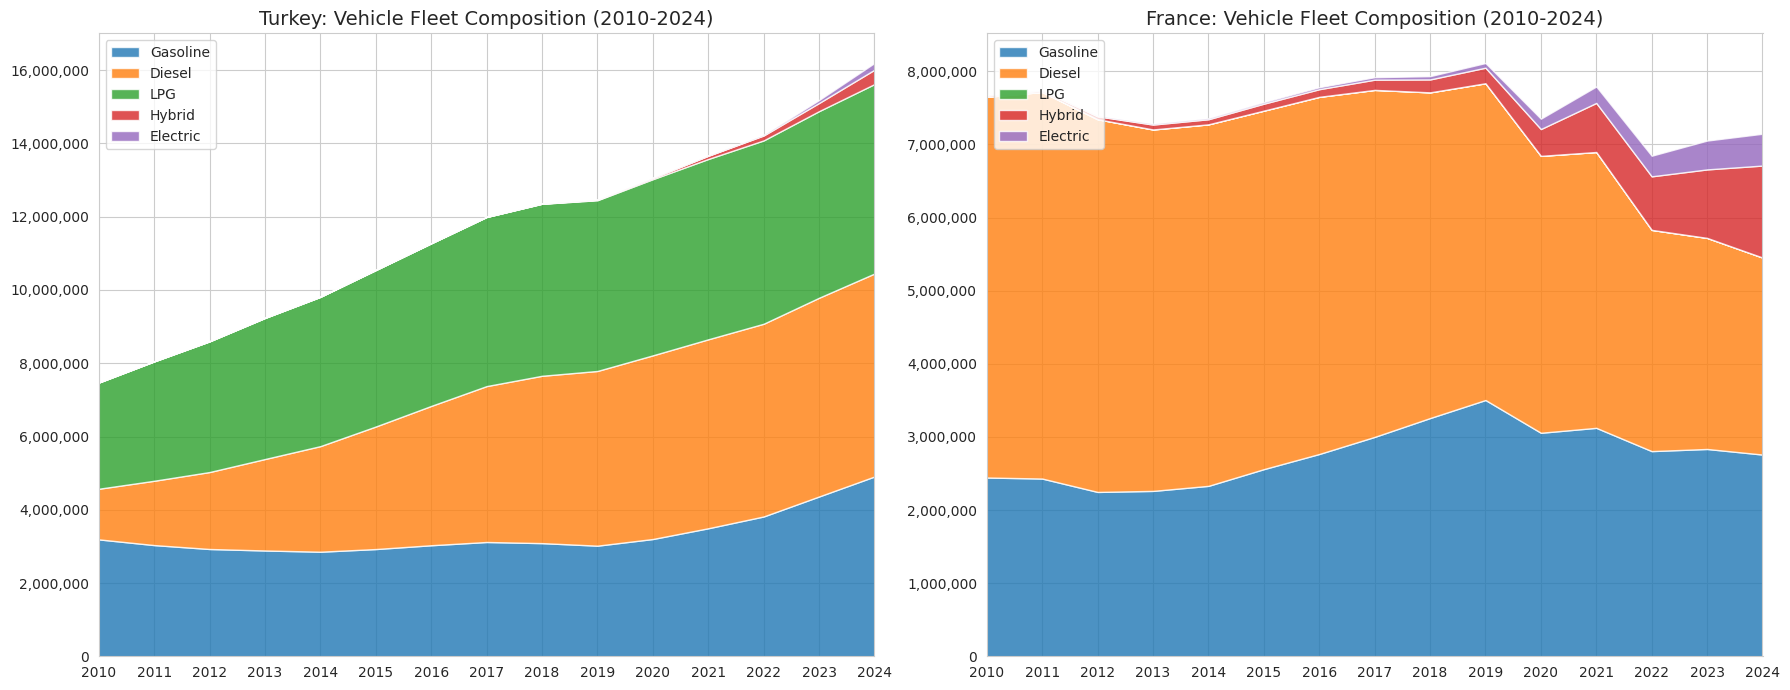

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# --- 1. DATA PROCESSING ---

def clean_value(x):
    """Robust cleaner to convert '1 234' or '1,234' to float, handling errors."""
    if pd.isna(x) or str(x).strip() in ['', '-', 'nan']:
        return 0.0
    if isinstance(x, (int, float)):
        return float(x)
    try:
        # Remove spaces (common in Turkey data) and commas
        return float(str(x).replace(' ', '').replace(',', ''))
    except ValueError:
        return np.nan

def get_turkey_data_2010_2024():
    """Loads Turkey CSV, translates columns, cleans numbers, filters 2010-2024."""
    try:
        # Header is on row 2 (index 2) based on inspection
        df = pd.read_csv('turkey.csv', header=2)
    except FileNotFoundError:
        print("Error: turkey.csv not found")
        return pd.DataFrame()

    # Clean whitespace in column names
    df.columns = df.columns.str.strip()

    # Map Turkish columns to English
    col_map = {
        'Yıl': 'Year',
        'Toplam': 'Total_Vehicles',
        'Benzin': 'Gasoline',
        'Dizel': 'Diesel',
        'LPG': 'LPG',
        'Elektrik': 'Electric',
        'Hibrit': 'Hybrid'
    }

    renamed = {}
    for col in df.columns:
        for k, v in col_map.items():
            if k in col:
                renamed[col] = v
                break
    df = df.rename(columns=renamed)

    # Remove any rows where 'Year' is not a number (e.g. subheaders)
    df['Year_Clean'] = pd.to_numeric(df['Year'], errors='coerce')
    df = df.dropna(subset=['Year_Clean'])
    df = df.drop(columns=['Year_Clean'])

    # Ensure necessary columns exist and fill NaNs with 0
    cols_of_interest = ['Year', 'Total_Vehicles', 'Electric', 'Gasoline', 'Diesel', 'LPG', 'Hybrid']
    for c in cols_of_interest:
        if c not in df.columns: df[c] = 0

    # Apply number cleaning to all columns
    for c in df.columns:
        df[c] = df[c].apply(clean_value)

    # Filter STRICTLY 2010-2024
    df = df[(df['Year'] >= 2010) & (df['Year'] <= 2024)].copy()

    # Calculate Market Share
    df['EV_Market_Share_Pct'] = (df['Electric'] / df['Total_Vehicles']) * 100
    df['Country'] = 'Turkey'

    return df

def get_france_data_2010_2024():
    """Loads France CSV, translates logic, cleans numbers, filters 2010-2024."""
    try:
        df_raw = pd.read_csv('france.csv', header=None)
    except FileNotFoundError:
        print("Error: france.csv not found")
        return pd.DataFrame()

    # Find the row containing '2010' to use as header
    try:
        idx = df_raw[df_raw.apply(lambda r: r.astype(str).str.contains('2010').any(), axis=1)].index[0]
    except IndexError:
        return pd.DataFrame()

    headers = df_raw.iloc[idx]
    df_data = df_raw.iloc[idx+1:].copy()
    df_data.columns = headers

    # Helper to sum rows based on French keywords (Translating logic)
    def get_row_sums(keywords, exclude=[]):
        label_col = df_data.columns[0]
        # Case-insensitive search
        mask = df_data[label_col].astype(str).str.contains(keywords[0], case=False, na=False)
        for k in keywords[1:]:
            mask |= df_data[label_col].astype(str).str.contains(k, case=False, na=False)
        for k in exclude:
            mask &= ~df_data[label_col].astype(str).str.contains(k, case=False, na=False)

        subset = df_data[mask]
        years = [c for c in df_data.columns if str(c).isdigit()]
        sums = {}
        for y in years:
            sums[int(y)] = subset[y].apply(clean_value).sum()
        return sums

    # Extract Data
    totals = get_row_sums(['Total'])
    electrics = get_row_sums(['lectrique'], exclude=['Hybride'])
    gasolines = get_row_sums(['Essence'], exclude=['GLP', 'Hybride', 'rechargeable'])
    diesels = get_row_sums(['Diesel'], exclude=['Hybride', 'rechargeable'])
    lpgs = get_row_sums(['GLP'])
    hybrids = get_row_sums(['Hybride'])

    # Build DataFrame
    data = []
    for y in totals.keys():
        if 2010 <= y <= 2024:
            t = totals[y]
            e = electrics[y]
            g = gasolines[y]
            d = diesels[y]
            l = lpgs[y]
            h = hybrids[y]

            data.append({
                'Year': y,
                'Country': 'France',
                'Total_Vehicles': t,
                'Electric': e,
                'Gasoline': g,
                'Diesel': d,
                'LPG': l,
                'Hybrid': h,
                'EV_Market_Share_Pct': (e/t)*100 if t > 0 else 0
            })

    return pd.DataFrame(data)

# --- 2. EXECUTION ---

def main():
    # Load Data
    df_turkey = get_turkey_data_2010_2024()
    df_france = get_france_data_2010_2024()

    if df_turkey.empty or df_france.empty:
        print("Data loading failed.")
        return

    df_combined = pd.concat([df_turkey, df_france], ignore_index=True)

    # Print Raw Numbers Sample
    print(f"\n \n{'='*30}\n DATA SAMPLE (2010-2024)\n{'='*30}")
    print(df_combined[['Year', 'Country', 'Total_Vehicles', 'Electric', 'EV_Market_Share_Pct']].sort_values(['Country', 'Year']).to_string(index=False))

    # --- 3. PLOTTING ---

    # Plot 1: Vehicle Counts Comparison
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # Total Vehicles
    sns.lineplot(data=df_combined, x='Year', y='Total_Vehicles', hue='Country', ax=axes[0], marker='o', palette={'Turkey': '#d62728', 'France': '#1f77b4'})
    axes[0].set_title('Total Vehicles Count (2010-2024)', fontsize=14)
    axes[0].set_xlim(2010, 2024)
    axes[0].set_xticks(range(2010, 2025))
    axes[0].get_yaxis().set_major_formatter(FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Electric Vehicles
    sns.lineplot(data=df_combined, x='Year', y='Electric', hue='Country', ax=axes[1], marker='o', palette={'Turkey': '#d62728', 'France': '#1f77b4'})
    axes[1].set_title('Electric Vehicles Count (2010-2024)', fontsize=14)
    axes[1].set_xlim(2010, 2024)
    axes[1].set_xticks(range(2010, 2025))
    axes[1].get_yaxis().set_major_formatter(FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig('historical_counts_2010_2024.png')
    print("Saved historical_counts_2010_2024.png")

    # Plot 2: EV Market Share
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.lineplot(data=df_combined, x='Year', y='EV_Market_Share_Pct', hue='Country', marker='o', palette={'Turkey': '#d62728', 'France': '#1f77b4'})
    plt.title('EV Market Share (%) Trends (2010-2024)', fontsize=16)
    plt.xlim(2010, 2024)
    plt.xticks(range(2010, 2025), rotation=45)
    plt.ylabel('Market Share (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('historical_share_2010_2024.png')
    print("Saved historical_share_2010_2024.png")

    # Plot 3: Fuel Mix (Stacked Area)
    fuel_types = ['Gasoline', 'Diesel', 'LPG', 'Hybrid', 'Electric']
    # Ensure columns exist in case some are missing/renamed
    for ft in fuel_types:
        if ft not in df_combined.columns: df_combined[ft] = 0

    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=False)
    countries = ['Turkey', 'France']

    for i, country in enumerate(countries):
        data = df_combined[df_combined['Country'] == country].sort_values('Year')
        if data.empty: continue

        axes[i].stackplot(data['Year'], [data[ft] for ft in fuel_types], labels=fuel_types, alpha=0.8)
        axes[i].set_title(f'{country}: Vehicle Fleet Composition (2010-2024)', fontsize=14)
        axes[i].legend(loc='upper left')
        axes[i].set_xlim(2010, 2024)
        axes[i].set_xticks(range(2010, 2025))
        axes[i].get_yaxis().set_major_formatter(FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    plt.tight_layout()
    plt.savefig('historical_fuel_mix_2010_2024.png')
    print("Saved historical_fuel_mix_2010_2024.png")

if __name__ == "__main__":
    main()

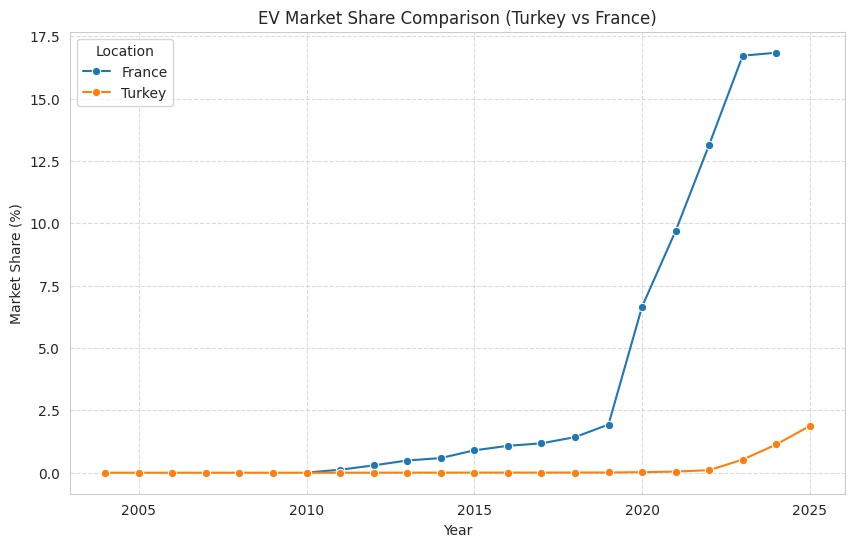


 MODELING RESULTS
Country  LR RMSE  ARIMA RMSE Best Model
 Turkey    1.262       1.058      ARIMA
 France    8.823       3.087      ARIMA

 FUTURE PREDICTIONS
Turkey (2026): Predicted EV Market Share -> 2.65%
France (2025): Predicted EV Market Share -> 17.2%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
import re
from io import StringIO

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# --- 1. DATA LOADING AND CLEANING ---

# A. TURKEY DATA
# Header is on row 3 (index 2)
try:
    df_turkey = pd.read_csv('turkey.csv', header=2, encoding='utf-8')
except FileNotFoundError:
    print("Error: turkey.csv not found.")
    df_turkey = pd.DataFrame(columns=['Yıl', 'Toplam', 'Elektrik', ' Hibrit (2)'])

# Remove the English sub-header row if it exists (where 'Yıl' equals 'Year')
df_turkey = df_turkey[df_turkey['Yıl'] != 'Year']

# Select and rename relevant columns
turkey_cols = ['Yıl', 'Toplam', 'Elektrik', ' Hibrit (2)']
# Ensure columns exist before selecting
available_cols = [c for c in turkey_cols if c in df_turkey.columns]
df_tr = df_turkey[available_cols].copy()

# Rename columns to English
df_tr.columns = ['Year', 'Total_Car_Count', 'Electric', 'Hybrid']

# Numeric cleaning function for Turkey (handles spaces and dashes)
def clean_turkey_number(x):
    if pd.isna(x): return 0
    if isinstance(x, str):
        x = x.strip()
        if x == '-' or x == '': return 0
        x = x.replace(' ', '') # Remove spaces (e.g., "1 000")
    try:
        return float(x)
    except ValueError:
        return 0.0

# Year cleaning function (e.g., "2025(1)" -> 2025)
def clean_year(x):
    if pd.isna(x): return None
    s = str(x)
    match = re.match(r'(\d{4})', s)
    if match: return int(match.group(1))
    return None

df_tr['Year'] = df_tr['Year'].apply(clean_year)
df_tr = df_tr.dropna(subset=['Year'])

for col in ['Total_Car_Count', 'Electric', 'Hybrid']:
    if col in df_tr.columns:
        df_tr[col] = df_tr[col].apply(clean_turkey_number)

# Fill NaN with 0 and add Location tag
df_tr = df_tr.fillna(0)
df_tr['Location'] = 'Turkey'

# B. FRANCE DATA
# Reading line by line to extract the specific block
try:
    with open('france.csv', 'r', encoding='utf-8') as f:
        lines = f.readlines()

    # Find start of "New Cars" (Voitures neuves) block
    start_idx = next(i for i, line in enumerate(lines) if line.startswith("Voitures neuves"))
    # Find end of block (empty comma line or end of file)
    end_idx = next((i for i, line in enumerate(lines) if i > start_idx and line.strip() == ",,,,,,,,,,,,,,,") , len(lines))

    france_block = lines[start_idx:end_idx]
    df_france_raw = pd.read_csv(StringIO("".join(france_block)))

    # Transpose to make Years the rows
    df_fr_t = df_france_raw.set_index('Voitures neuves').T
    df_fr_t.index.name = 'Year'
    df_fr_t = df_fr_t.reset_index()

    # Clean column names (strip whitespace)
    df_fr_t.columns = [c.strip() for c in df_fr_t.columns]

    # Numeric cleaning function for France (handles commas/decimals)
    def clean_france_number(x):
        if pd.isna(x): return 0
        if isinstance(x, str):
            x = x.strip()
            if x == '.' or x == '': return 0
            x = x.replace(',', '') # Remove thousands separator if present
        try:
            return float(x)
        except ValueError:
            return 0.0

    df_fr_t['Year'] = df_fr_t['Year'].apply(clean_year)
    cols_to_clean = df_fr_t.columns.drop('Year')
    for col in cols_to_clean:
        df_fr_t[col] = df_fr_t[col].apply(clean_france_number)

    df_fr_t = df_fr_t.fillna(0)

    # Standardize Column Names
    # Map 'Electric and hydrogen' to 'Electric'
    if 'Électrique et hydrogène' in df_fr_t.columns:
        df_fr_t['Electric'] = df_fr_t['Électrique et hydrogène']
    else:
        df_fr_t['Electric'] = 0

    df_fr_t['Total_Car_Count'] = df_fr_t['Total']

    # Sum Hybrid types
    hybrid_cols = ['Essence - hybride non rechargeable', 'Diesel - hybride non rechargeable', 'Hybride rechargeable']
    present_hybrid_cols = [c for c in hybrid_cols if c in df_fr_t.columns]
    df_fr_t['Hybrid'] = df_fr_t[present_hybrid_cols].sum(axis=1)

    df_fr_t['Location'] = 'France'

except Exception as e:
    print(f"Error processing France data: {e}")
    df_fr_t = pd.DataFrame(columns=['Year', 'Total_Car_Count', 'Electric', 'Hybrid', 'Location'])

# --- 2. FEATURE ENGINEERING AND MERGING ---

# Calculate EV Market Share Percentage
for df in [df_tr, df_fr_t]:
    if not df.empty:
        df['EV_Market_Share_Pct'] = df.apply(
            lambda row: (row['Electric'] / row['Total_Car_Count'] * 100) if row['Total_Car_Count'] > 0 else 0,
            axis=1
        )

# Merge Datasets
final_cols = ['Year', 'Total_Car_Count', 'Electric', 'Hybrid', 'EV_Market_Share_Pct', 'Location']
df_combined = pd.concat([df_tr[final_cols], df_fr_t[final_cols]], ignore_index=True)

# Filter for valid years (e.g., 2010 onwards)
df_combined['Year'] = pd.to_numeric(df_combined['Year'], errors='coerce')
df_combined = df_combined.dropna(subset=['Year'])
df_combined['Year'] = df_combined['Year'].astype(int)
df_combined = df_combined.sort_values(by=['Location', 'Year'])

# --- 3. VISUALIZATION ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_combined, x='Year', y='EV_Market_Share_Pct', hue='Location', marker='o')
plt.title('EV Market Share Comparison (Turkey vs France)')
plt.ylabel('Market Share (%)')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('ev_market_share_comparison.png') # Save plot
plt.show()

# --- 4. MODELING (Prediction) ---
results = []
predictions = {}

print(f"\n{'='*40}\n MODELING RESULTS\n{'='*40}")

for country in ['Turkey', 'France']:
    df_c = df_combined[df_combined['Location'] == country].sort_values('Year')

    if len(df_c) < 5:
        print(f"Not enough data for {country}")
        continue

    # Split: Train (All except last 3 years), Test (Last 3 years)
    train = df_c.iloc[:-3]
    test = df_c.iloc[-3:]

    X_train, y_train = train[['Year']], train['EV_Market_Share_Pct']
    X_test, y_test = test[['Year']], test['EV_Market_Share_Pct']

    # 1. Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

    # 2. ARIMA
    # Using a try-except block to find a convergent model
    arima_pred = []
    try:
        # Try Order (1,1,1)
        arima = ARIMA(y_train, order=(1,1,1)).fit()
        arima_pred = arima.forecast(steps=len(test)).values
    except:
        try:
            # Fallback to Order (1,1,0)
            arima = ARIMA(y_train, order=(1,1,0)).fit()
            arima_pred = arima.forecast(steps=len(test)).values
        except:
            # If ARIMA fails, use dummy prediction (mean)
            arima_pred = [y_train.mean()] * len(test)

    arima_rmse = np.sqrt(mean_squared_error(y_test, arima_pred))

    # Determine Best Model
    best_model_name = "ARIMA" if arima_rmse < lr_rmse else "Linear Regression"
    results.append({
        'Country': country,
        'LR RMSE': round(lr_rmse, 3),
        'ARIMA RMSE': round(arima_rmse, 3),
        'Best Model': best_model_name
    })

    # Predict Next Year using the Best Model (trained on ALL data)
    next_year = df_c['Year'].max() + 1
    full_y = df_c['EV_Market_Share_Pct'].reset_index(drop=True)

    if best_model_name == "ARIMA":
        # Refit on full data
        try:
            final_model = ARIMA(full_y, order=(1,1,1)).fit()
        except:
            final_model = ARIMA(full_y, order=(1,1,0)).fit()
        pred_val = final_model.forecast(steps=1).values[0]
    else:
        final_model = LinearRegression().fit(df_c[['Year']], full_y)
        pred_val = final_model.predict([[next_year]])[0]

    predictions[country] = (next_year, round(pred_val, 2))

# Output Results
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print(f"\n{'='*40}\n FUTURE PREDICTIONS\n{'='*40}")
for country, (year, val) in predictions.items():
    print(f"{country} ({year}): Predicted EV Market Share -> {val}%")

Forecast Report (2025-2030):

Turkey Projections:
2026: 2.65%
2027: 3.40%
2028: 4.12%
2029: 4.81%
2030: 5.49%

France Projections:
2025: 17.20%
2026: 17.45%
2027: 17.64%
2028: 17.78%
2029: 17.88%
2030: 17.96%


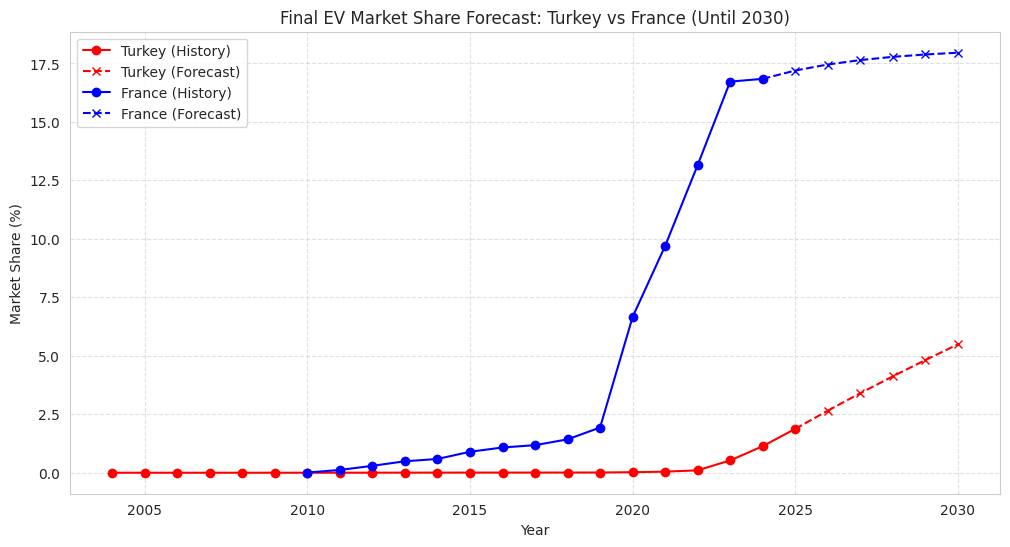

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
import re
from io import StringIO

warnings.filterwarnings("ignore")

# ==========================================
# 1. HELPER FUNCTIONS
# ==========================================
def clean_number(x):
    """Robustly converts strings with spaces/commas to float."""
    if pd.isna(x): return 0.0
    s = str(x).replace(' ', '').replace(',', '')
    if s in ['', '-', 'nan', '.']: return 0.0
    try: return float(s)
    except: return 0.0

def clean_year(x):
    """Extracts 4-digit year from strings like '2025(1)'."""
    if pd.isna(x): return None
    match = re.search(r'(\d{4})', str(x))
    if match: return int(match.group(1))
    return None

# ==========================================
# 2. DATA LOADING & PROCESSING
# ==========================================

# --- Turkey Data ---
# Read CSV skipping initial description lines
df_tr_raw = pd.read_csv('turkey.csv', header=2, encoding='utf-8')
# Remove English sub-header row
df_tr_raw = df_tr_raw[df_tr_raw['Yıl'] != 'Year']

df_tr = pd.DataFrame()
df_tr['Year'] = df_tr_raw['Yıl'].apply(clean_year)
df_tr = df_tr.dropna(subset=['Year'])
df_tr['Total'] = df_tr_raw['Toplam'].apply(clean_number)
df_tr['Electric'] = df_tr_raw['Elektrik'].apply(clean_number)
df_tr['Country'] = 'Turkey'
# Calculate Share
df_tr['EV_Share'] = (df_tr['Electric'] / df_tr['Total'] * 100).fillna(0)


# --- France Data ---
# Read file line-by-line to isolate the "Voitures neuves" block
with open('france.csv', 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Find start and end of the relevant block
start = next(i for i, l in enumerate(lines) if "Voitures neuves" in l)
end = next((i for i, l in enumerate(lines) if i > start and l.strip() == ",,,,,,,,,,,,,,,") , len(lines))

# Parse block
df_fr_raw = pd.read_csv(StringIO("".join(lines[start:end])))

# Transpose so Years become rows
df_fr_t = df_fr_raw.set_index(df_fr_raw.columns[0]).T.reset_index()
df_fr_t.columns = ['Year'] + [c.strip() for c in df_fr_t.columns[1:]]

df_fr = pd.DataFrame()
df_fr['Year'] = df_fr_t['Year'].apply(clean_year)
df_fr = df_fr.dropna(subset=['Year'])
df_fr['Total'] = df_fr_t['Total'].apply(clean_number)

# Find Electric column (flexible match)
col_elec = [c for c in df_fr_t.columns if 'lectrique' in c][0]
df_fr['Electric'] = df_fr_t[col_elec].apply(clean_number)
df_fr['Country'] = 'France'
# Calculate Share
df_fr['EV_Share'] = (df_fr['Electric'] / df_fr['Total'] * 100).fillna(0)


# --- Combine ---
df_combined = pd.concat([df_tr, df_fr], ignore_index=True)
df_combined['Year'] = df_combined['Year'].astype(int)

# ==========================================
# 3. VISUALIZATION & FORECASTING
# ==========================================

plt.figure(figsize=(12, 6))
print("Forecast Report (2025-2030):")

for country, color in [('Turkey', 'red'), ('France', 'blue')]:
    # Filter Data for Country
    data = df_combined[df_combined['Country'] == country].sort_values('Year')

    # Prepare lists for iterative forecasting
    y_values = list(data['EV_Share'])
    years_hist = list(data['Year'])
    last_year = years_hist[-1]

    forecast_years = []
    forecast_values = []

    current_year = last_year
    target_year = 2030

    # Iterative ARIMA Forecast Loop
    while current_year < target_year:
        try:
            # Try ARIMA(1,1,1) first
            model = ARIMA(y_values, order=(1,1,1)).fit()
            next_val = model.forecast(steps=1)[0]
        except:
            # Fallback to simpler ARIMA(1,1,0)
            model = ARIMA(y_values, order=(1,1,0)).fit()
            next_val = model.forecast(steps=1)[0]

        # Append prediction to history for next step
        y_values.append(next_val)
        current_year += 1
        forecast_years.append(current_year)
        forecast_values.append(next_val)

    # --- PLOTTING ---
    # Plot History
    plt.plot(years_hist, data['EV_Share'], marker='o', label=f'{country} (History)', color=color)
    # Plot Forecast
    plt.plot(forecast_years, forecast_values, linestyle='--', marker='x', label=f'{country} (Forecast)', color=color)
    # Connect line between history and forecast
    plt.plot([last_year, forecast_years[0]], [data['EV_Share'].iloc[-1], forecast_values[0]], linestyle='--', color=color)

    # Print Values
    print(f"\n{country} Projections:")
    for y, v in zip(forecast_years, forecast_values):
        print(f"{y}: {v:.2f}%")

plt.title('Final EV Market Share Forecast: Turkey vs France (Until 2030)')
plt.xlabel('Year')
plt.ylabel('Market Share (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Forecasting 2025-2030:
------------------------------
Turkey 2030 Projection: 5.49%
France 2030 Projection: 17.96%
------------------------------
Plot saved as 'enhanced_ev_forecast.png'


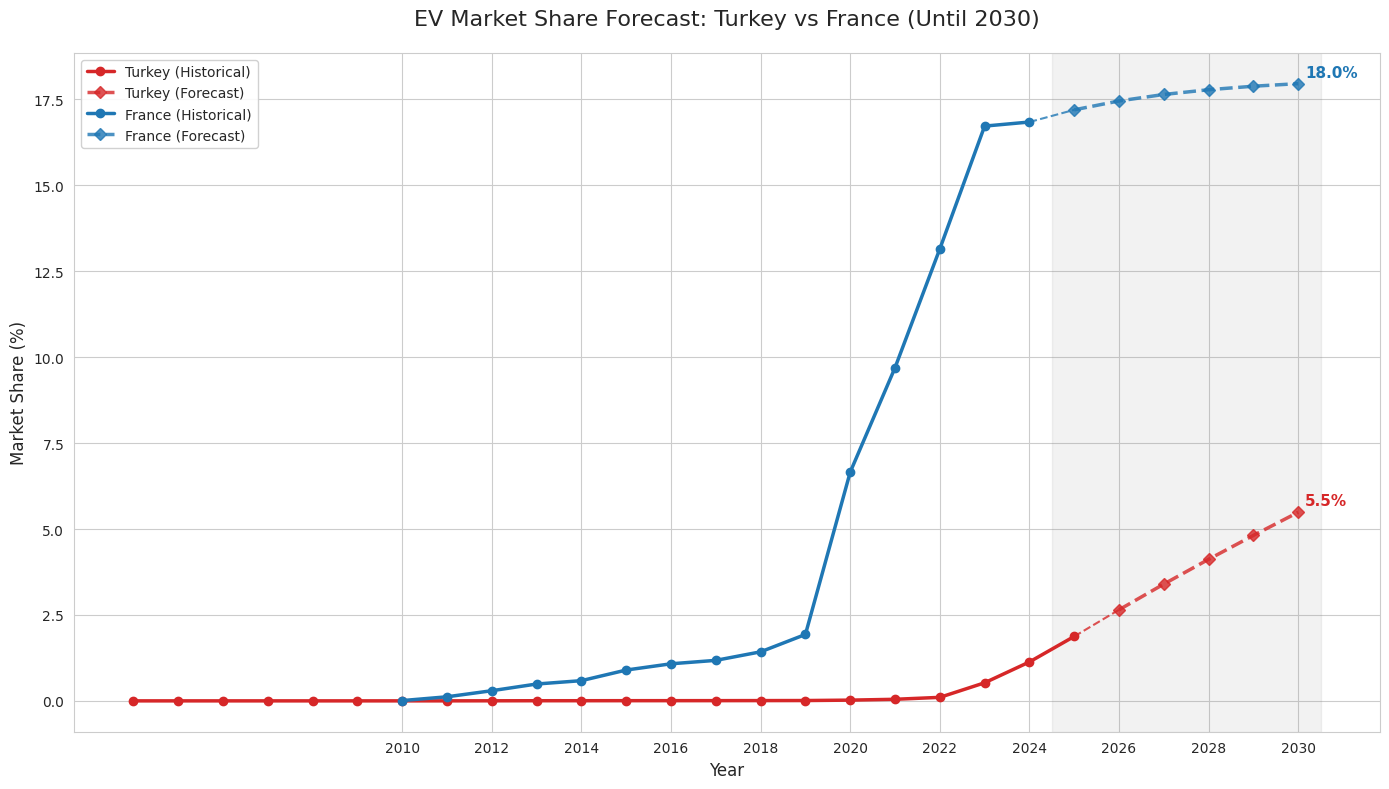

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
import re
from io import StringIO

warnings.filterwarnings("ignore")

# ==========================================
# 1. DATA CLEANING HELPERS
# ==========================================

def clean_number(x):
    """
    Robustly converts strings with spaces (e.g., '1 234') or commas to float.
    """
    if pd.isna(x): return 0.0
    s = str(x).strip()
    # Remove thousand separators (spaces and commas)
    s = s.replace(' ', '').replace(',', '')
    if s in ['', '-', 'nan', '.', 'Total']: return 0.0
    try:
        return float(s)
    except ValueError:
        return 0.0

def clean_year(x):
    """Extracts 4-digit year from strings like '2025(1)'."""
    if pd.isna(x): return None
    match = re.search(r'(\d{4})', str(x))
    if match:
        return int(match.group(1))
    return None

# ==========================================
# 2. DATA LOADING
# ==========================================

def load_data():
    """Loads and merges Turkey and France data."""

    # --- TURKEY DATA ---
    try:
        df_tr_raw = pd.read_csv('turkey.csv', header=2, encoding='utf-8')
    except:
        df_tr_raw = pd.read_csv('turkey.csv', header=2, encoding='latin1')

    df_tr_raw = df_tr_raw[df_tr_raw['Yıl'] != 'Year'] # Remove sub-header

    df_tr = pd.DataFrame()
    df_tr['Year'] = df_tr_raw['Yıl'].apply(clean_year)
    df_tr = df_tr.dropna(subset=['Year'])
    df_tr['Total'] = df_tr_raw['Toplam'].apply(clean_number)
    df_tr['Electric'] = df_tr_raw['Elektrik'].apply(clean_number)
    df_tr['Country'] = 'Turkey'

    # --- FRANCE DATA ---
    try:
        with open('france.csv', 'r', encoding='utf-8') as f: lines = f.readlines()
    except:
        with open('france.csv', 'r', encoding='latin1') as f: lines = f.readlines()

    # Extract "Voitures neuves" block
    start = next(i for i, l in enumerate(lines) if "Voitures neuves" in l)
    end = next((i for i, l in enumerate(lines) if i > start and l.strip() == ",,,,,,,,,,,,,,,") , len(lines))

    df_fr_raw = pd.read_csv(StringIO("".join(lines[start:end])))

    # Transpose to (Year, Columns) format
    df_fr_t = df_fr_raw.set_index(df_fr_raw.columns[0]).T.reset_index()
    df_fr_t.columns = ['Year'] + [c.strip() for c in df_fr_t.columns[1:]]

    df_fr = pd.DataFrame()
    df_fr['Year'] = df_fr_t['Year'].apply(clean_year)
    df_fr = df_fr.dropna(subset=['Year'])
    df_fr['Total'] = df_fr_t['Total'].apply(clean_number)

    # Find Electric column (flexible search)
    col_elec = [c for c in df_fr_t.columns if 'lectrique' in c][0]
    df_fr['Electric'] = df_fr_t[col_elec].apply(clean_number)
    df_fr['Country'] = 'France'

    # --- COMBINE ---
    df = pd.concat([df_tr, df_fr], ignore_index=True)
    df['Year'] = df['Year'].astype(int)

    # Filter valid data and calculate share
    df = df[df['Total'] > 0]
    df['EV_Share'] = (df['Electric'] / df['Total'] * 100)

    return df

# ==========================================
# 3. FORECASTING & VISUALIZATION
# ==========================================

def run_analysis():
    # Load Data
    df = load_data()

    # Setup Plot Style
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 8))

    colors = {'Turkey': '#d62728', 'France': '#1f77b4'}

    print("Forecasting 2025-2030:\n" + "-"*30)

    for country in ['Turkey', 'France']:
        # Prepare Data
        data = df[df['Country'] == country].sort_values('Year')
        hist_years = list(data['Year'])
        hist_values = list(data['EV_Share'])
        last_year = hist_years[-1]

        # --- ARIMA Loop ---
        current_y = list(hist_values)
        curr_year = last_year
        target_year = 2030

        future_years = []
        future_values = []

        while curr_year < target_year:
            try:
                # ARIMA(1,1,1) is standard for this type of growth trend
                model = ARIMA(current_y, order=(1,1,1)).fit()
                next_val = model.forecast(steps=1)[0]
            except:
                # Fallback to ARIMA(1,1,0) if optimization fails
                model = ARIMA(current_y, order=(1,1,0)).fit()
                next_val = model.forecast(steps=1)[0]

            current_y.append(next_val)
            curr_year += 1
            future_years.append(curr_year)
            future_values.append(next_val)

        # Print Results
        print(f"{country} 2030 Projection: {future_values[-1]:.2f}%")

        # --- Plotting ---
        # 1. Historical Line
        plt.plot(hist_years, hist_values, marker='o', linewidth=2.5,
                 label=f'{country} (Historical)', color=colors[country])

        # 2. Forecast Line
        plt.plot(future_years, future_values, linestyle='--', marker='D', linewidth=2.5,
                 alpha=0.8, label=f'{country} (Forecast)', color=colors[country])

        # 3. Connect Lines
        plt.plot([last_year, future_years[0]], [hist_values[-1], future_values[0]],
                 linestyle='--', color=colors[country], alpha=0.8)

        # 4. Annotate 2030 Value
        plt.annotate(f'{future_values[-1]:.1f}%',
                     xy=(2030, future_values[-1]),
                     xytext=(5, 5), textcoords='offset points',
                     fontsize=11, fontweight='bold', color=colors[country])

    # Finalize Plot
    plt.title('EV Market Share Forecast: Turkey vs France (Until 2030)', fontsize=16, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Market Share (%)', fontsize=12)
    plt.legend(loc='upper left', frameon=True, framealpha=0.9)
    plt.xticks(range(2010, 2031, 2))

    # Add shaded forecast zone
    plt.axvspan(2024.5, 2030.5, color='gray', alpha=0.1, label='Forecast Zone')

    plt.tight_layout()
    plt.savefig('enhanced_ev_forecast.png', dpi=300)
    print("-" * 30)
    print("Plot saved as 'enhanced_ev_forecast.png'")
    plt.show()

# Run the script
if __name__ == "__main__":
    run_analysis()